# Retirement Planner

---

## Environment Setup

In [1]:
# Import libraries and dependencies

import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Set the random seed for resutls reproducibility (for testing purposes only)

np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
# Load .env enviroment variables

from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret

alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Create the Alpaca API object

api = tradeapi.REST(alpaca_api_key,alpaca_secret_key,api_version="v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [4]:
# Subset your tickers, then pull returns data:
# Set the ticker

ticker = ["SPY", "AGG"]

# Set timeframe to '1D'

timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.

start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG

df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns

df = df.drop(
    columns=['open', 'high', 'low', 'volume'],
    level=1
)

In [5]:
# Display sample data

df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `500` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [6]:
# Calculate the daily roi for the stocks

daily_returns = df.pct_change()

avg_daily_return_AGG = daily_returns.mean()['AGG']['close']
avg_daily_return_SPY = daily_returns.mean()['SPY']['close']

# Display sample data

print(avg_daily_return_AGG, avg_daily_return_SPY)

0.00021276976507473064 0.0010397627326754729


In [7]:
# Compute daily volatility

std_dev_daily_return_AGG = daily_returns.std()['AGG']['close']
std_dev_daily_return_SPY = daily_returns.std()['SPY']['close']
print(std_dev_daily_return_AGG, std_dev_daily_return_SPY)

0.0020886019741764646 0.007821228920771257


In [8]:
# Save the last day's closing price

AGG_last_price = df['AGG']['close'][-1]
SPY_last_price = df['SPY']['close'][-1]

In [9]:
# Setup the Monte Carlo Parameters

number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()

# Initialize the simulated prices list with the last closing price of AGG/SPY

simulated_AGG_prices = [AGG_last_price]
simulated_SPY_prices = [SPY_last_price]

# Initialize empty DataFrame to hold simulated prices for each simulation

simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `500` times

for n in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price of `AGG` and `SPY`
    
    simulated_AGG_prices = [AGG_last_price]
    simulated_SPY_prices = [SPY_last_price]
    
    # Simulate the returns for 252 * 30 days
    
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        
        simulated_AGG_price = simulated_AGG_prices[-1] * (1 + np.random.normal(avg_daily_return_AGG, std_dev_daily_return_AGG))
        simulated_SPY_price = simulated_SPY_prices[-1] * (1 + np.random.normal(avg_daily_return_SPY, std_dev_daily_return_SPY))
        
        
        # Append the simulated price to the list
        
        simulated_AGG_prices.append(simulated_AGG_price)
        simulated_SPY_prices.append(simulated_SPY_price)
    
    # Append the simulated prices of each simulation to DataFrame
    
    simulated_price_df["AGG prices"] = pd.Series(simulated_AGG_prices)
    simulated_price_df["SPY prices"] = pd.Series(simulated_SPY_prices)
    
    # Calculate the daily returns of simulated prices
    
    simulated_daily_returns = simulated_price_df.pct_change()
    
    # Set the portfolio weights (40% AGG; 60% SPY)
    
    weights = [0.40, 0.60]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
   
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

In [10]:
# Run the Monte Carlo Simulation

portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000475,1.000536,0.998808,1.005395,1.011798,0.994450,0.997249,1.013279,1.000868,0.995375,...,1.002066,0.992708,1.001800,1.002671,0.996472,1.003160,1.001638,1.006801,0.998172,0.994764
2,1.008876,1.004700,1.003591,0.996710,1.009571,0.994245,0.994211,1.007202,1.000225,0.993033,...,1.005759,0.994515,1.003316,1.006181,0.997471,0.991772,1.002764,1.005410,0.996136,0.998870
3,1.008286,1.004228,1.003771,0.998232,1.007751,0.987666,0.998226,1.001363,1.000229,1.001276,...,1.006771,0.988440,1.004116,1.010566,0.993292,0.994452,1.008273,0.999143,0.998654,1.003328
4,1.013962,1.006575,1.008494,1.002635,1.013664,0.990970,1.003240,0.995492,1.002046,1.006035,...,1.004195,0.992120,1.004722,1.004421,0.994842,0.993780,1.005723,1.002247,0.996961,1.004094


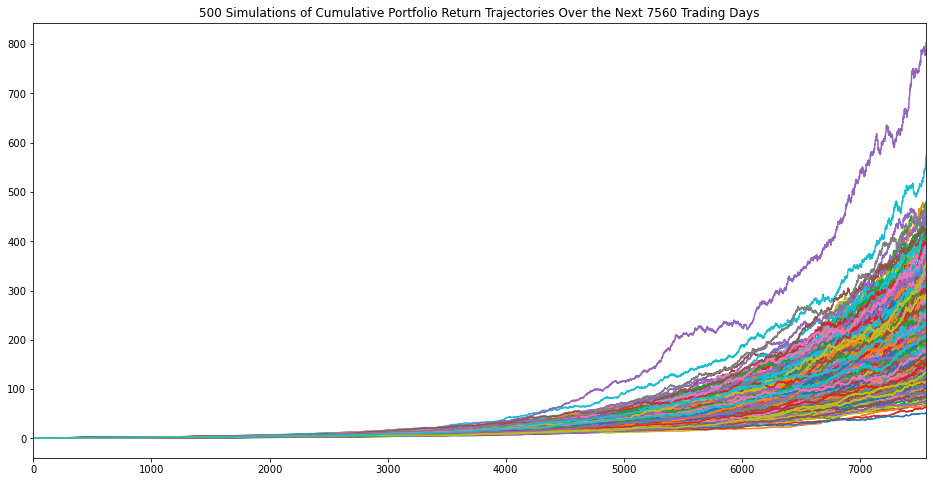

In [11]:
# Visualize the Simulation

plot_title = f"{n+1} Simulations of Cumulative Portfolio Return Trajectories Over the Next {252*30} Trading Days"
portfolio_cumulative_returns.plot(legend=None, title=plot_title, figsize = (16,8))

In [12]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)

ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    192.447672
1    171.674293
2    177.691905
3    138.221133
4    175.326232
Name: 7560, dtype: float64

In [14]:
# Display the 90% confidence interval for the ending returns

confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    102.644055
0.95    378.748460
Name: 7560, dtype: float64

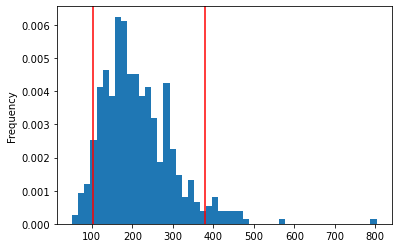

In [15]:
# Visualize the distribution of the ending returns

plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=50)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [16]:
# Compute cumulative returns

confidence_interval2 = ending_cumulative_returns.quantile(q=[0.1, 0.5, 0.9])
confidence_interval2

0.1    118.823435
0.5    198.760708
0.9    320.037000
Name: 7560, dtype: float64

### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [17]:
# Set initial investment

initial_investment = 20000

# Compute expected portfolio return

investment_pnl_lower_bound = initial_investment + (initial_investment * confidence_interval2.iloc[0])
investment_pnl_middle_bound = initial_investment + (initial_investment * confidence_interval2.iloc[1])
investment_pnl_upper_bound = initial_investment + (initial_investment * confidence_interval2.iloc[2])

# Print the results

print(f"There is a 80% chance that an initial investment of $20,000 in the portfolio"
      f" over the next {252*30} trading days will end within in the range of"
      f" ${investment_pnl_lower_bound}, ${investment_pnl_middle_bound}, and ${investment_pnl_upper_bound}")

There is a 80% chance that an initial investment of $20,000 in the portfolio over the next 7560 trading days will end within in the range of $2396468.6965719922, $3995214.169236292, and $6420740.004980851


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [23]:
# Set Plaid's projected income

plaid_projected_income = 6085

# Calculate the 4% withdrawal for the ending return as retirement income

retirement_income = 0.04 * (initial_investment * ending_cumulative_returns.quantile(0.1))

# Determine if the retirement income meets or exceeds the current projected income

retirement_income

95058.7478628797

Given that the Plaid retirement income is only $6085, it appears a 4% withdraw from the 10th percentile of the portfolio would exceed that.

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [19]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount

initial_investment2 = 30000

retirement_income2 = 0.04 * (initial_investment2 * ending_cumulative_returns.quantile(0.1))
retirement_income2

142588.12179431954